# Telemetry Filtering Example

In [11]:
import numpy as np

from Chandra.Time import DateTime
import Ska.engarchive.fetch_eng as fetch
from Ska.Matplotlib import plot_cxctime

%matplotlib inline

The following code is pulled from the "fot_trend" package located here: github.com/fot/fot_trend. I wrote these functions to be able to calculate stats from data that might be missing values in some of the "bins", in this case these bins are 24 hours.

I am including it here (slightly modified) so you don't have to worry about keeping a local copy of this package.

In [2]:
def calc_daily_stats(t, dmin, dmean, dmax):
    """ Calculate daily stats
    :param t: Time numpy array
    :param dmin: Minimum statistical data in a numpy array
    :param dmean: Mean statistical data in a numpy array
    :param dmax: Maximum statistical data in a numpy array
    Note: dmin, dmean, and dmax are meant to include the 5min statistical data from the ska
    archive. 
    This method can use raw values instead of statistical values if the same raw values are passed
    for each the dmin, dmean, and dmax positional arguments.
    """

    daystart = DateTime(DateTime(t[0]).date[:8] + ':00:00:00.000').secs
    daystop = DateTime(DateTime(t[-1]).date[:8] + ':00:00:00.000').secs

    daysecs = 3600.* 24.
    days = np.arange(daystart, daystop + daysecs, daysecs)
    ind = digitizebins(t, days)

    daymins = np.array([np.nanmin(dmin[i[0]:(i[-1]+1)]) if i[-1] - i[0] > 0 else np.nan for i in ind])
    daymeans = np.array([np.nanmean(dmean[i[0]:(i[-1]+1)]) if i[-1] - i[0] > 0 else np.nan for i in ind])
    daymaxes = np.array([np.nanmax(dmax[i[0]:(i[-1]+1)]) if i[-1] - i[0] > 0 else np.nan for i in ind])

    return days, daymins, daymeans, daymaxes


def digitizebins(data, bins):
    """ Calculate indices to binned data
    :param data: 1d data array to be divided up into bins
    :param bins: 1d array of bin boundaries
    :returns: array of start and stop indices
    Note: at this point, data needs to be sequential. I intend on generalizing this function for
    non sequential data, however that will come as an enhancement in the future.
    """
    databins = np.digitize(data, bins=bins)
    b = np.bincount(databins - 1)
    c = np.hstack((0, np.cumsum(b)))
    return np.array([(k1, k2-1) for k1, k2 in zip(c[:-1], c[1:])])

First, fetch the data. You'll want to use the `Msidset` method so all values can be interpolated on the same scale.

In [3]:
vmsids = ['4MP5AV', '4MP28AV', '4MP5BV', '4MP28BV']
smsids = ['4M5IRAX', '4M28IRAX', '4M5IRBX', '4M28IRBX']
data = fetch.Msidset(vmsids + smsids, '2016:001', '2016:183:02:00:00', stat=None)

Next find the minimum sampling rate. You could avoid this step if you already know the sampling rate, but here I find it automatically.

In [4]:
dt = 32.8
for msid in vmsids + smsids:
    dt = np.min((np.min(np.diff(data[msid].times)), dt))
dt

0.25624990463256836

The next statement just interpolates all values to the same set of time values. This can take a little while and may take up a relatively large amount of memory. If you find memory becomes a problem, you can pull the msids of interest along with their status msids separately. I suggest doing this if you are pulling data for the whole mission at once.

In [5]:
data.interpolate(dt)

Next I am checking to see what the state codes are for the indicator msids.

In [6]:
data[smsids[0]].state_codes

[(0, 'DISA'), (1, 'ENAB')]

Next I filter for only the voltage telemetry where the status msid shows "ENAB". I do this for the first msids "4MP5AV" + "4M5IRAX". You can repeat this for the other msid pairs as needed.

In [7]:
keep = data[smsids[0]].vals == 'ENAB'
vals = data[vmsids[0]].vals[keep]
times = data.times[keep]

Below I use a function I wrote to calculate the daily statistics. This function was originally written to use the "5min" data which includes separate arrays for min, mean, and max values. I can optionally pass in the full resolution data for each of these values; this is why you see the "vals" array input three times. 

This function can not account for different sampling rates, but because we already interpolated all values into a uniform sampling rate, we don't need to worry about accounting for that.

This function calculates the mean statistics over supplied data, so if there are only two values for that day passed to this function, the mean for that day will be the mean of those to values and won't be skewed by invalid/missing datapoints.

All missing data uses the NaN value, so any full days without any supplied data will report NaNs for the statistical values for that day. This generally plays nicely with numpy and matplotlib methods.

In [8]:
times, daymins, daymeans, daymaxes = calc_daily_stats(times, vals, vals, vals)

Statistical values for each day are time tagged with the time at the beginning of that day.

You'll notice that the last date in the returned data is the last full day in the fetched dataset. 

In [9]:
DateTime(times[-1]).date

'2016:182:00:00:00.000'

Here I use the `plot_cxctime` function to plot the data. You'll notice there are gaps in the plotted data, this is where NaN values are inserted to indicate days where no valid data was recorded (i.e. when the box was off).

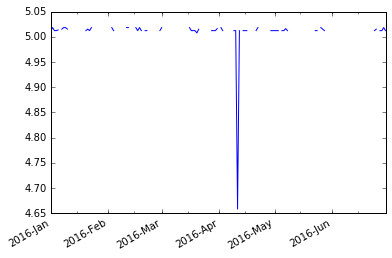

In [10]:
_ = plot_cxctime(times, daymeans)